In [1]:
import os
import openai
import io
import uuid
import base64
from base64 import b64decode
import numpy as np
from PIL import Image

from unstructured.partition.pdf import partition_pdf

from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

from operator import itemgetter

In [2]:
in_path = "./ml/input/"
tmp_path = "./ml/temp/"

In [3]:
def doc_partition(in_path,file_name, tmp_path):

  raw_pdf_elements = partition_pdf(
    filename = in_path + file_name,
    image_output_dir_path=tmp_path,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    )

  return raw_pdf_elements

raw_pdf_elements = doc_partition(in_path,"pet-api.pdf", tmp_path)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def data_category(raw_pdf_elements): # we may use decorator here
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
           tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
           texts.append(str(element))
    data_category = [texts,tables]
    return data_category
texts = data_category(raw_pdf_elements)[0]
tables = data_category(raw_pdf_elements)[1]

In [5]:
def tables_summarize(data_category):
    prompt_text = """You are an assistant tasked with summarizing tables and text. \
                    Give a concise summary of the table or text. Table or text chunk: {element} """

    prompt = ChatPromptTemplate.from_template(prompt_text)
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()
    table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})
    #text_summaries =  summarize_chain.batch(data_category[0], {"max_concurrency": 5})# no need to summarize

    return table_summaries
table_summaries = tables_summarize(data_category)
text_summaries = texts

In [6]:
def encode_image(image_path):
    ''' Getting the base64 string '''
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def image_captioning(img_base64,prompt):
    ''' Image summary '''
    chat = ChatOpenAI(model="gpt-4-vision-preview",
                      max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text":prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                        },
                    },
                ]
            )
        ]
    )
    return msg.content

In [7]:
import time
# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = "Describe the image in detail. Be specific about graphs, such as bar plots."

# Read images, encode to base64 strings
for img_file in sorted(os.listdir(tmp_path)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(tmp_path, img_file)
        print(img_path)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        #image_summaries.append(image_captioning(base64_image,prompt))
        img_cap = image_captioning(base64_image,prompt)
        #time.sleep(60)
        image_summaries.append(img_cap)


./ml/temp/figure-1-1.jpg
./ml/temp/figure-2-1.jpg
./ml/temp/figure-2-2.jpg
./ml/temp/figure-2-3.jpg
./ml/temp/figure-3-4.jpg
./ml/temp/figure-3-5.jpg
./ml/temp/figure-4-6.jpg
./ml/temp/figure-4-7.jpg
./ml/temp/figure-5-8.jpg
./ml/temp/figure-5-9.jpg
./ml/temp/figure-6-10.jpg
./ml/temp/figure-6-11.jpg
./ml/temp/figure-7-12.jpg


In [8]:
def split_image_text_types(docs):
    ''' Split base64-encoded images and texts '''
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }

In [9]:
# Add raw docs and doc summaries to Multi Vector Retriever.
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag",
                     embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [10]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda, RunnableParallel

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
                Question: {dict["question"]}
                Text and tables:
                {format_texts}
                """},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
            ]
        )
    ]

model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableParallel({"response":prompt_func| model| StrOutputParser(),
                      "context": itemgetter("context"),})
)

In [11]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

To invoke the Pet API, you should follow these steps:

1. Obtain a temporary token by making a call to the security/token API. Unfortunately, the specific details on how to call the Token API are not provided here, but you should refer to the API Integration Guide for that information.

2. Once you have the token, you can make a call to the functional API. For the MetLife Pet Insurance API, you have two environment URLs provided:

- For the Test Environment, use the following URL to call the Catalog API (Call #1):
  ```
  https://qa.api.metlife.com/metlife/qa/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100
  ```
  You will need to include the temporary token you obtained in the Authorization header of your request.

- For the Production Environment, the URL is similar but without the 'qa' subdomain:
  ```
  https://api.metlife.com/metlife/production/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100
  


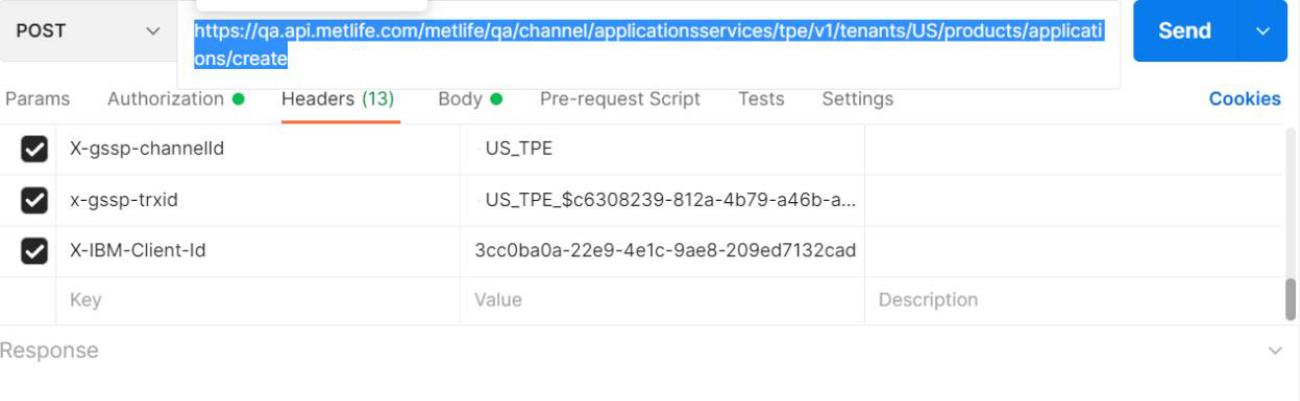

In [12]:
response = chain.invoke(
    "How do I invoke Pet API?"
)
print(response['response'])
plt_img_base64(response['context']['images'][0])

The image provided shows a screenshot of a response from an API call in a web-based API testing tool. The response is in JSON format and includes an array of items. The specific functional API that is visible in the screenshot seems to be related to retrieving catalog information, as indicated by the "typeCode": "catalogs" within the JSON structure.

The "catalogNames" array suggests that this API provides access to various catalogs, which include "colors", "genders", "species", and "weightRanges". These could be different endpoints or parameters within the functional API that allow consumers to retrieve information about these specific categories.

However, the text and tables context provided does not list the specific functional APIs available. It only describes the process of obtaining a security token from the Token API before calling a functional API. To know the full range of available functional APIs, one would typically need to refer to the API documentation provided by the se


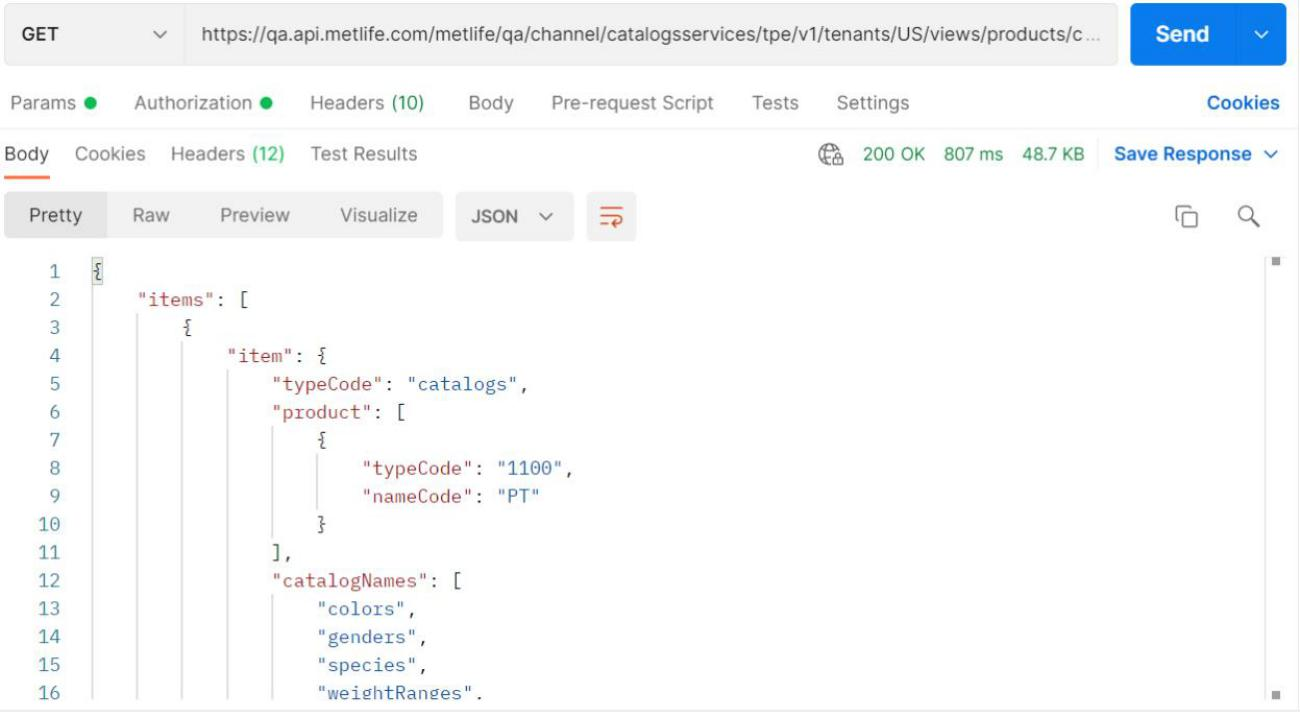

In [13]:
response = chain.invoke(
    "what are the available funtional APIs?"
)
print(response['response'])
plt_img_base64(response['context']['images'][0])

The GET request for the Catalog API in the test environment can be made to the following URL:

```
https://qa.api.metlife.com/metlife/qa/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100
```

This request is expected to return a list of items in a JSON format, as shown in the image, where the response includes an array of "items" with details such as "typeCode" and "nameCode" for the products, along with an array of "catalogNames" that includes "colors", "genders", "species", and "weightRanges".



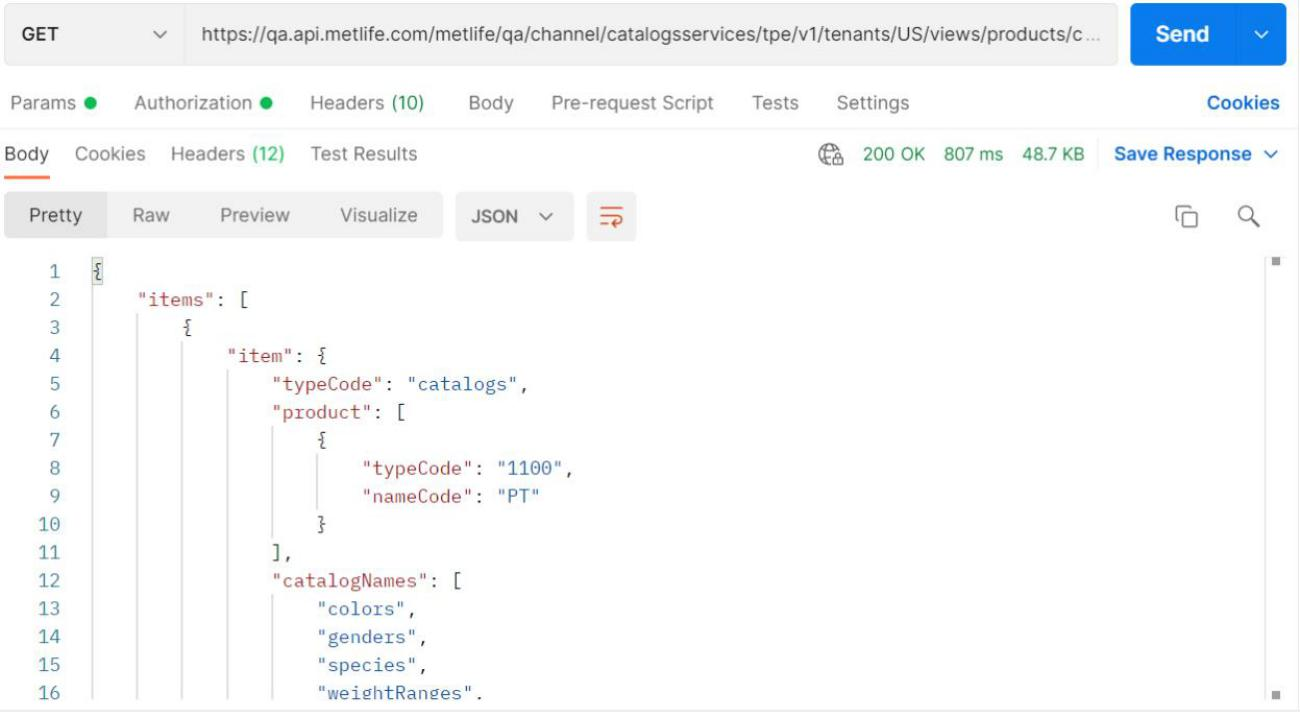

In [14]:
response = chain.invoke(
    "Show me Get request for Catalog API"
)
print(response['response'])
plt_img_base64(response['context']['images'][0])

Based on the provided context, here are the test URLs for each API:

1. Submit Application API (QA Environment):
   - https://qa.api.metlife.com/metlife/qa/channel/applicationsservices/tpe/v1/tenants/US/products/applications/8fd6e9cf-fbbb-48da-b008-91e009c2d542/submit

2. Retrieve Leads API (QA Environment):
   - https://qa.api.metlife.com/metlife/qa/channel/leadsservices/tpe/v1/tenants/US/views/products/leads/b708046d-30fd-4784-af41-d4520ab32bd8/consolidate?q=product.typeCode==1100

3. Security/Token API (QA Environment):
   - https://qa.api.metlife.com/metlife/qa/authorization/token

These are the URLs for the test environment as specified in the provided text.



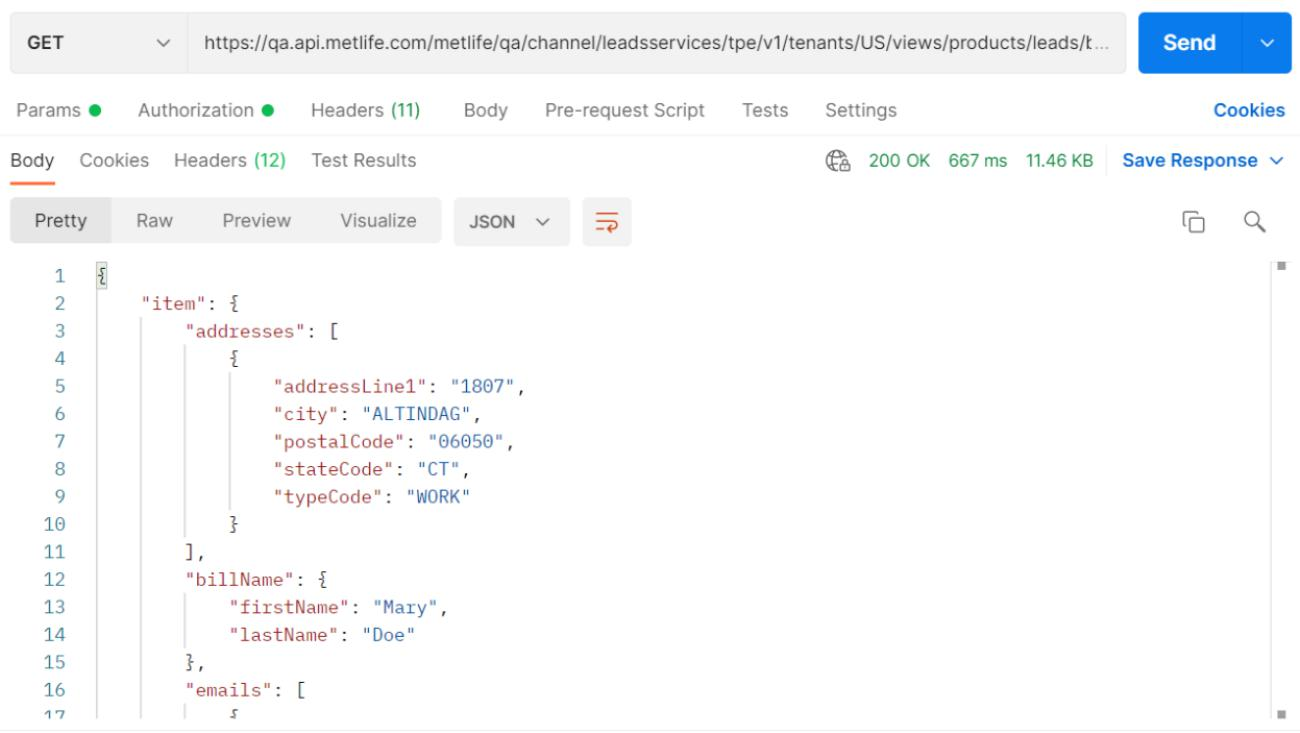

In [15]:
response = chain.invoke(
    "Give me test URLs for each API.",
)
print(response['response'])
plt_img_base64(response['context']['images'][0])